In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False # - 깨짐을 방지
fm._rebuild()

NanumBarunGothic


In [2]:
import pandas as pd
import numpy as np

# 데이터 전처리 1차

In [3]:
# 1. 서울시 CCTV 현황 데이터 불러오기
CCTV_seoul = pd.read_csv("/content/drive/MyDrive/Encore/데이터분석/data1/01. CCTV_in_Seoul.csv", encoding="utf-8")

In [4]:
CCTV_seoul.head(3)

,기관명,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,2780,1292,430,584,932
1,강동구,773,379,99,155,377
2,강북구,748,369,120,138,204


In [5]:
# 컬럼명 확인
CCTV_seoul.columns

Index(['기관명', '소계', '2013년도 이전', '2014년', '2015년', '2016년'], dtype='object')

In [6]:
CCTV_seoul.rename(columns={'기관명':'구별'}, inplace=True)
CCTV_seoul.columns

Index(['구별', '소계', '2013년도 이전', '2014년', '2015년', '2016년'], dtype='object')

In [7]:
# 2. 서울시 인구현황 데이터 불러오기
pop_Seoul = pd.read_excel("/content/drive/MyDrive/Encore/데이터분석/data1/01. population_in_Seoul.xls")
pop_Seoul.head(3)

,기간,자치구,세대,인구,인구.1,인구.2,인구.3,인구.4,인구.5,인구.6,인구.7,인구.8,세대당인구,65세이상고령자
0,기간,자치구,세대,합계,합계,합계,한국인,한국인,한국인,등록외국인,등록외국인,등록외국인,세대당인구,65세이상고령자
1,기간,자치구,세대,계,남자,여자,계,남자,여자,계,남자,여자,세대당인구,65세이상고령자
2,2017.1/4,합계,4202888,10197604,5000005,5197599,9926968,4871560,5055408,270636,128445,142191,2.36,1321458


In [8]:
# 분석에 필요한 부분한 추출하여 읽기 : header=엑셀 행(index)번호, usecols="엑셀컬럼명 ..."
pop_Seoul = pd.read_excel("/content/drive/MyDrive/Encore/데이터분석/data1/01. population_in_Seoul.xls", header=2, usecols="B, D, G, J, N")
# => B : 구이름, D : 인구수, G : 한국인, J : 외국인 ,N : 고령자(65세 이상)
pop_Seoul.head(3)

,자치구,계,계.1,계.2,65세이상고령자
0,합계,10197604.0,9926968.0,270636.0,1321458.0
1,종로구,162820.0,153589.0,9231.0,25425.0
2,중구,133240.0,124312.0,8928.0,20764.0


In [9]:
# 컬럼명 변경
pop_Seoul.rename(columns={pop_Seoul.columns[0] : "구별",
                          pop_Seoul.columns[1] : "인구수",
                          pop_Seoul.columns[2] : "한국인",
                          pop_Seoul.columns[3] : "외국인",
                          pop_Seoul.columns[4] : "고령자"
                          }, inplace=True)
pop_Seoul.head(3)

,구별,인구수,한국인,외국인,고령자
0,합계,10197604.0,9926968.0,270636.0,1321458.0
1,종로구,162820.0,153589.0,9231.0,25425.0
2,중구,133240.0,124312.0,8928.0,20764.0


# 데이터 전처리 2차

In [10]:
# 3. CCTV 데이터 파악하기
CCTV_seoul.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,2780,1292,430,584,932
1,강동구,773,379,99,155,377
2,강북구,748,369,120,138,204
3,강서구,884,388,258,184,81
4,관악구,1496,846,260,390,613


In [11]:
CCTV_seoul.tail()

,구별,소계,2013년도 이전,2014년,2015년,2016년
20,용산구,1624,1368,218,112,398
21,은평구,1873,1138,224,278,468
22,종로구,1002,464,314,211,630
23,중구,671,413,190,72,348
24,중랑구,660,509,121,177,109


In [12]:
# 소계 컬럼을 기준으로 정렬시킨 후, 상위/하위 5개 데이터 확인
CCTV_seoul.sort_values(by="소계", ascending=False)[:5]

,구별,소계,2013년도 이전,2014년,2015년,2016년
0,강남구,2780,1292,430,584,932
18,양천구,2034,1843,142,30,467
14,서초구,1930,1406,157,336,398
21,은평구,1873,1138,224,278,468
20,용산구,1624,1368,218,112,398


In [13]:
CCTV_seoul.sort_values(by="소계", ascending=True)[:5]

,구별,소계,2013년도 이전,2014년,2015년,2016년
9,도봉구,485,238,159,42,386
12,마포구,574,314,118,169,379
17,송파구,618,529,21,68,463
24,중랑구,660,509,121,177,109
23,중구,671,413,190,72,348


In [14]:
# '최근증가율' 칼럼 추가 : 2013년 이전과 그 이후에 대한 CCTV 증가율
# 데이터프레임에 칼럼 추가 : DataFrame['추가칼럼명'] = 추가될 데이터
# 증가율 = 2014년 + 2015년 + 2016년 / 2013년 이전 * 100
CCTV_seoul['최근증가율'] = (CCTV_seoul['2014년'] + CCTV_seoul['2015년'] + CCTV_seoul['2016년']) / CCTV_seoul['2013년도 이전'] * 100
CCTV_seoul.sort_values(by='최근증가율', ascending=False).head()

,구별,소계,2013년도 이전,2014년,2015년,2016년,최근증가율
22,종로구,1002,464,314,211,630,248.922414
9,도봉구,485,238,159,42,386,246.638655
12,마포구,574,314,118,169,379,212.101911
8,노원구,1265,542,57,451,516,188.929889
1,강동구,773,379,99,155,377,166.490765


In [15]:
# 4. 서울시 인구 데이터 파악하기
# 결측치 확인 : isnull() / 유일한 값 : unique() / 행 삭제 : drop()

# 합계에 해당하는 행 삭제
pop_Seoul.drop([0], inplace=True)

In [16]:
# '구별' 칼럼 유일한 값 확인
pop_Seoul['구별'].unique()

array(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구', nan],
      dtype=object)

In [17]:
# '구별' 칼럼에 결측치 여부 확인
pop_Seoul[pop_Seoul['구별'].isnull()]

,구별,인구수,한국인,외국인,고령자
26,NaN,NaN,NaN,NaN,NaN


In [18]:
# 결측치 행 삭제
pop_Seoul.drop([26], inplace=True)

In [19]:
# '외국인비율', '고령자비율' 칼럼 추가
# '외국인비율' = '외국인' / '인구수' * 100
pop_Seoul['외국인비율'] = pop_Seoul['외국인'] / pop_Seoul['인구수'] * 100

# '고령자비율' = '고령자' / '인구수' * 100
pop_Seoul['고령자비율'] = pop_Seoul['고령자'] / pop_Seoul['인구수'] * 100

In [20]:
# 인구수 / 외국인/ 외국인비율 / 고령자 / 고령자비율 을 기준으로 각가 정렬하여 데이터 확인
pop_Seoul.sort_values(by="인구수", ascending=False).head(5)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
24,송파구,667483.0,660584.0,6899.0,72506.0,1.033584,10.862599
16,강서구,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
23,강남구,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
11,노원구,569384.0,565565.0,3819.0,71941.0,0.670725,12.634883
21,관악구,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


In [21]:
pop_Seoul.sort_values(by="외국인", ascending=False).head(5)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,402985.0,368072.0,34913.0,52413.0,8.663598,13.006191
17,구로구,447874.0,416487.0,31387.0,56833.0,7.007998,12.689506
18,금천구,255082.0,236353.0,18729.0,32970.0,7.342345,12.925255
21,관악구,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291
6,동대문구,369496.0,354079.0,15417.0,54173.0,4.172440,14.661322


In [22]:
pop_Seoul.sort_values(by="외국인비율", ascending=False).head(5)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,402985.0,368072.0,34913.0,52413.0,8.663598,13.006191
18,금천구,255082.0,236353.0,18729.0,32970.0,7.342345,12.925255
17,구로구,447874.0,416487.0,31387.0,56833.0,7.007998,12.689506
2,중구,133240.0,124312.0,8928.0,20764.0,6.700690,15.583909
3,용산구,244203.0,229456.0,14747.0,36231.0,6.038828,14.836427


In [23]:
pop_Seoul.sort_values(by="고령자", ascending=False).head(5)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
16,강서구,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
24,송파구,667483.0,660584.0,6899.0,72506.0,1.033584,10.862599
12,은평구,494388.0,489943.0,4445.0,72334.0,0.899091,14.631019
11,노원구,569384.0,565565.0,3819.0,71941.0,0.670725,12.634883
21,관악구,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


In [24]:
pop_Seoul.sort_values(by="고령자비율", ascending=False).head(5)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
9,강북구,330192.0,326686.0,3506.0,54813.0,1.061806,16.600342
1,종로구,162820.0,153589.0,9231.0,25425.0,5.669451,15.615404
2,중구,133240.0,124312.0,8928.0,20764.0,6.700690,15.583909
3,용산구,244203.0,229456.0,14747.0,36231.0,6.038828,14.836427
13,서대문구,327163.0,314982.0,12181.0,48161.0,3.723221,14.720797


# 분석작업

In [25]:
# 5. CCTV 데이터와 인구 데이터 합치고 분석하기
# 만약 두 개의 데이터프레임에 공통 프레임이 없는 경우 : left_on=컬럼명, right_on=컬럼명
# on="공통컬럼명"
data_result = pd.merge(CCTV_seoul, pop_Seoul, on="구별")
data_result.head()

,구별,소계,2013년도 이전,2014년,2015년,2016년,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,2780,1292,430,584,932,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
1,강동구,773,379,99,155,377,166.490765,453233.0,449019.0,4214.0,54622.0,0.929765,12.051638
2,강북구,748,369,120,138,204,125.203252,330192.0,326686.0,3506.0,54813.0,1.061806,16.600342
3,강서구,884,388,258,184,81,134.793814,603772.0,597248.0,6524.0,72548.0,1.080540,12.015794
4,관악구,1496,846,260,390,613,149.290780,525515.0,507203.0,18312.0,68082.0,3.484582,12.955291


In [26]:
# 연도별 강남 3구에 대한 안전부분을 분석하지 않고, 전체에 대한 안전 여부 분석하기 위해 불필요 요소 제거
data_result.drop(['2013년도 이전'], axis=1, inplace=True)
data_result.drop(['2014년'], axis=1, inplace=True)
data_result.drop(['2015년'], axis=1, inplace=True)
data_result.drop(['2016년'], axis=1, inplace=True)
data_result.columns

Index(['구별', '소계', '최근증가율', '인구수', '한국인', '외국인', '고령자', '외국인비율', '고령자비율'], dtype='object')

In [27]:
# 분석 작업 후 향후 시각화를 위해 '구별' 칼럼의 데이터를 index 값으로 설정 : DataFrame.set_index('index로 사용될 칼럼명')
data_result.set_index('구별', inplace=True)
data_result.head(3)

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,2780,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217
강동구,773,166.490765,453233.0,449019.0,4214.0,54622.0,0.929765,12.051638
강북구,748,125.203252,330192.0,326686.0,3506.0,54813.0,1.061806,16.600342


In [28]:
# 각 데이터간의 연관성을 위한 상관관계 확인
# 상관관계 : numpy.corrcoef()
# 고령자비율과 소계간의 상관관계 확인
np.corrcoef(data_result['고령자비율'], data_result['소계'])

array([[ 1.        , -0.28078554],
       [-0.28078554,  1.        ]])

In [29]:
# 외국인비율과 소계간의 상관관계 확인
np.corrcoef(data_result['외국인비율'], data_result['소계'])

array([[ 1.        , -0.13607433],
       [-0.13607433,  1.        ]])

In [30]:
# 인구수와 소계간의 상관관계 확인
np.corrcoef(data_result['인구수'], data_result['소계'])

array([[1.        , 0.30634228],
       [0.30634228, 1.        ]])

In [31]:
# 6. matplotlib를 이용하여 CCTV와 인구현황 그래프로 분석
plt.rcParams['axes.unicode_minus'] = False

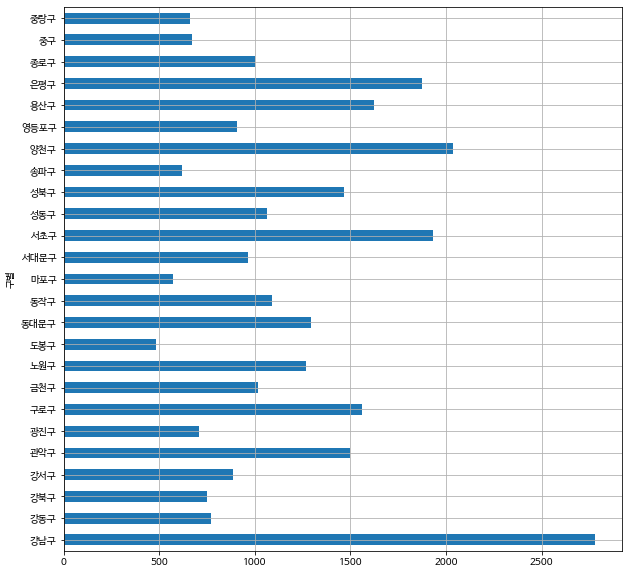

In [32]:
# 구별 / 소계 데이터 시각화
plt.figure()
data_result['소계'].plot(kind="barh", grid=True, figsize=(10, 10))
plt.show()

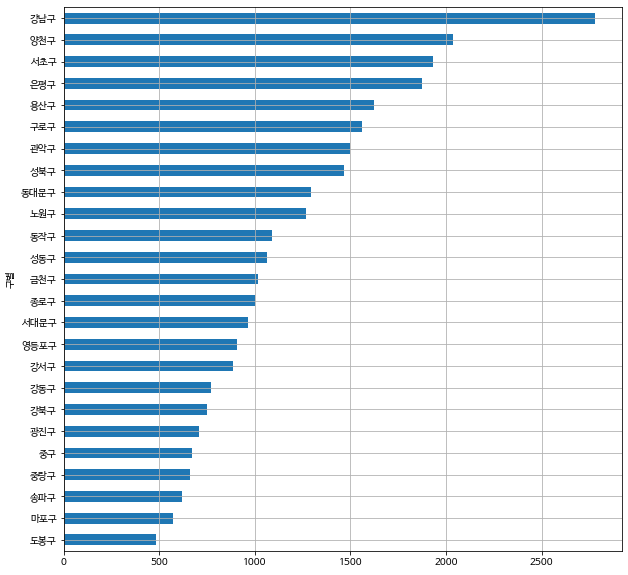

In [33]:
# 소계를 기준으로 정렬시켜 시각화
data_result['소계'].sort_values().plot(kind='barh', grid=True, figsize=(10, 10))
plt.show()

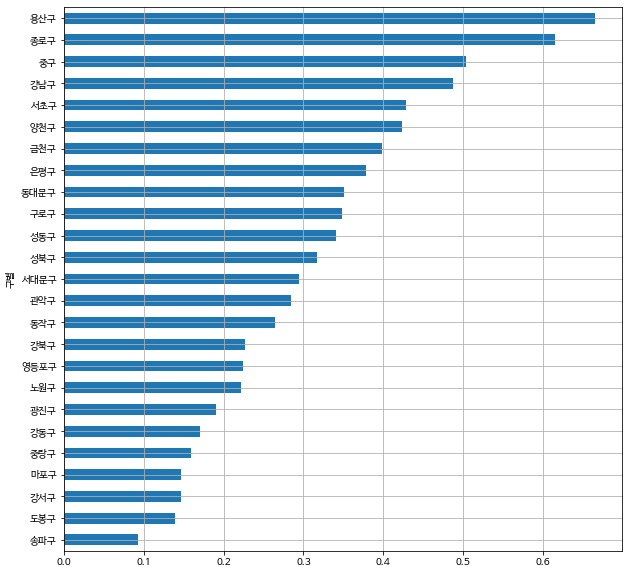

In [34]:
# 인구대비 CCTV 비율 시각화
data_result['CCTV비율'] = data_result['소계'] / data_result['인구수'] * 100
data_result['CCTV비율'].sort_values().plot(kind='barh', grid=True, figsize=(10, 10))
plt.show()

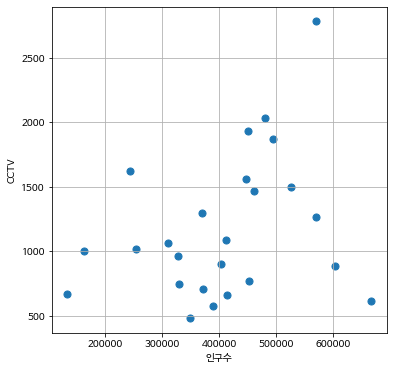

In [35]:
# 인구수와 CCTV비율에 대한 산점도 시각화
plt.figure(figsize=(6,6))
plt.scatter(data_result['인구수'], data_result['소계'], s=50)
plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.grid()
plt.show()

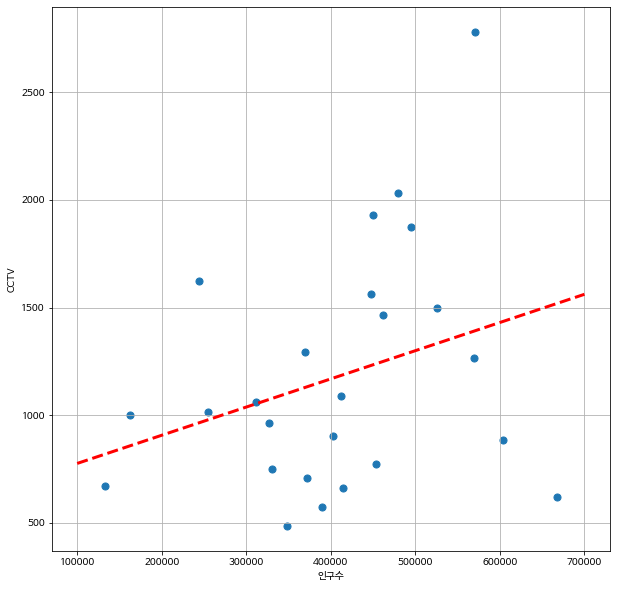

In [36]:
# 인구수와 CCTV비율에 대한 산점도에 선형회귀선 시각화
fp1 = np.polyfit(data_result['인구수'], data_result['소계'], 1)
f1 = np.poly1d(fp1)
fx = np.linspace(100000, 700000, 100)
plt.figure(figsize=(10, 10))
plt.scatter(data_result['인구수'], data_result['소계'], s=50)
plt.plot(fx, f1(fx), ls='dashed', lw=3, color='r')
plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.grid()
plt.show()

In [37]:
# 7. 보다 설득력 있는 자료 작업
fp1 = np.polyfit(data_result['인구수'], data_result['소계'], 1)
f1 = np.poly1d(fp1)
fx = np.linspace(100000, 700000, 100)

In [38]:
# 오차 구하기 : 만약 오차가 '-' 값이 나눌수도 있으므로 abs()를 이용하여 절대값으로 변경
data_result['오차'] = np.abs(data_result['소계'] - f1(data_result['인구수']))
df_sort = data_result.sort_values(by="오차", ascending=False)
df_sort.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,CCTV비율,오차
구별,,,,,,,,,,
강남구,2780,150.619195,570500.0,565550.0,4950.0,63167.0,0.867660,11.072217,0.487292,1388.055355
송파구,618,104.347826,667483.0,660584.0,6899.0,72506.0,1.033584,10.862599,0.092587,900.911312
양천구,2034,34.671731,479978.0,475949.0,4029.0,52975.0,0.839413,11.036964,0.423769,760.563512
서초구,1930,63.371266,450310.0,445994.0,4316.0,51733.0,0.958451,11.488308,0.428594,695.403794
용산구,1624,53.216374,244203.0,229456.0,14747.0,36231.0,6.038828,14.836427,0.665020,659.231690


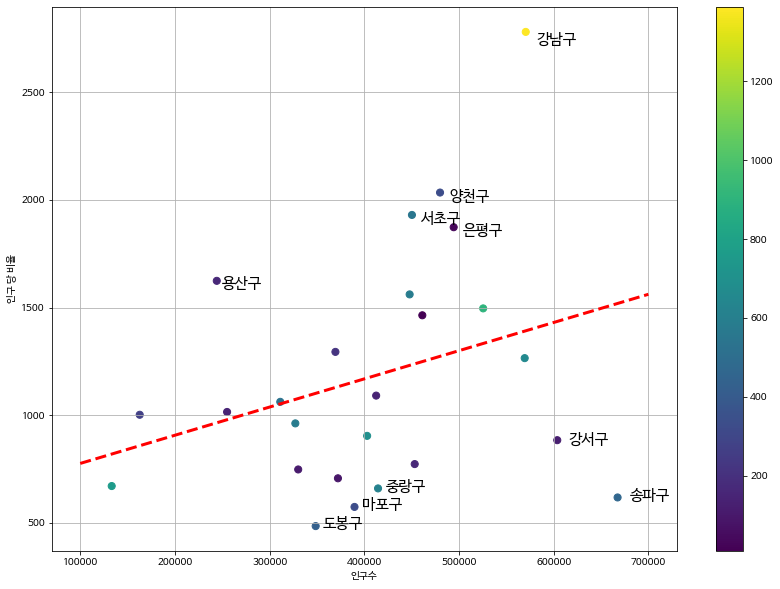

In [39]:
plt.figure(figsize=(14, 10))
plt.scatter(df_sort['인구수'], df_sort['소계'], c=data_result['오차'], s=50)
plt.plot(fx, f1(fx), ls='dashed', lw=3, color='r')
for n in range(10):
    plt.text(df_sort['인구수'][n]*1.02, df_sort['소계'][n]*0.98, df_sort.index[n], fontsize=15)
plt.xlabel('인구수')
plt.ylabel('인구 당 비율')
plt.colorbar()
plt.grid()
plt.show()

# 결론
서울시에서 다른 구에 비해 강남구, 양천구, 용산구, 서초구, 은평구는 인구대비 CCTV가 많고,
그에 비해 강서구, 송파구, 도봉구 등은 인구대비 CCTV 개수가 부족하다.
따라서 강남 3구 전체가 안전하다고 볼수는 없다.